In [2]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets, transforms, models 
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader, Dataset 

import sys
sys.path.append('/home/poz/Notebooks/645_Assignment2')
# from customScript import customScript

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
  print(f'Device {i} name:', torch.cuda.get_device_name(i))

batch_size = 32
image_resize = 224
num_workers = 4
num_epochs = 5
max_len = 24
best_loss = 1e+10
learning_rate = 2e-5
stats = (torch.tensor([0.4482, 0.4192, 0.3900]), torch.tensor([0.2918, 0.2796, 0.2709]))

CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device 0 name: NVIDIA GeForce RTX 2080 Ti


In [3]:
# Function to get thge statistics of a dataset
def get_dataset_stats(data_loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0.
    for data in data_loader:
        data = data[0] # Get the images to compute the statistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean,std

# Modify the imshow function to ensure stats are on the same device as the image
def imshow(img, stats):
    mean = stats[0].view(3, 1, 1).to(img.device)  # Move mean to the same device as img
    std = stats[1].view(3, 1, 1).to(img.device)   # Move std to the same device as img
    img = img * std + mean
    npimg = img.cpu().numpy()  # Convert the tensor back to numpy after moving it to CPU
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Test function
def test_model(model, dataloader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Define the model
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])
    return np.array(texts), np.array(labels)

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dataset, tokenizer, max_len):
        self.image_dataset = image_dataset
        self.class_names = image_dataset.classes
        self.tokenizer = tokenizer
        self.max_len = max_len
        #self.label_to_class_map = {i: self.class_names[i] for i in range(len(self.class_names))}
    def __len__(self):
        return len(self.image_dataset)
    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        image_path = self.image_dataset.samples[idx][0]
        text = os.path.splitext(os.path.basename(image_path))[0]
        text = re.sub(r'\d+', '', text).replace('_', ' ')
        #label = self.label_to_class_map[label]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)}

# Define training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        output = model(images, input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Define evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            output = model(images, input_ids, attention_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)  # Assuming input_ids are in the batch
            attention_mask = batch['attention_mask'].to(device)  # Assuming attention_mask is in the batch
            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            # Get predictions
            _, preds = torch.max(outputs, dim=1)
            # Convert predictions to CPU and append to the list
            predictions.extend(preds.cpu().numpy())
    return predictions

class MultiInputModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiInputModel, self).__init__()
        # Image model
        self.image_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = self.image_model.classifier[1].in_features
        self.image_model.classifier[1] = nn.Identity()  # Removing final classifier
        
        for param in self.image_model.parameters():
            param.requires_grad = True  # Fine-tune the image model
            
        # Text model
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 512)  # Reducing output size

        for param in self.text_model.parameters():
            param.requires_grad = True  # Fine-tune the text model
            
        # Combining both image and text features
        self.fc1 = nn.Linear(num_features + 512, 512)  # Merging both feature vectors
        self.fc2 = nn.Linear(512, 256)  # Reduced size
        self.fc3 = nn.Linear(256, num_classes)  # Output layer
        self.batch_norm1 = nn.BatchNorm1d(512)  # Batch Normalization after fc1
        self.batch_norm2 = nn.BatchNorm1d(256)  # Batch Normalization after fc2
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, image, input_ids, attention_mask):
        # Image features
        image_features = self.image_model.features(image)
        # print(f"Image features shape: {image_features.shape}")
        image_features = image_features.mean([2, 3])  # Global Average Pooling
        # print(f"Image features after pooling shape: {image_features.shape}")
        # Text features
        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_features[:, 0, :]  # Use [CLS] token for classification
        text_features = self.text_fc(text_features)  # Reduce the dimension
        # print(f"Text features shape: {text_features.shape}")
        # Combine image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)
        # print(f"Combined features shape: {combined_features.shape}")
        # Classifier with Batch Normalization, Activation functions, and Dropout
        x = self.fc1(combined_features)
        x = self.batch_norm1(x)  # Batch Normalization after fc1
        x = F.relu(x)  # ReLU activation after batch normalization
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)  # Batch Normalization after fc2
        x = F.relu(x)  # ReLU activation after batch normalization
        x = self.dropout(x)
        x = self.fc3(x)  # No activation for final output layer
        return x

class MultiModalDataset(Dataset):
    def __init__(self, image_dataset, tokenizer, max_len):
        self.image_dataset = image_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.image_dataset)
    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        image_path = self.image_dataset.samples[idx][0]
        text = os.path.splitext(os.path.basename(image_path))[0]
        text = re.sub(r'\d+', '', text).replace('_', ' ')
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [4]:
transform = {
    "train": transforms.Compose([
        transforms.RandomRotation(30),
        transforms.Resize((232, 232), interpolation=InterpolationMode.BILINEAR),
        transforms.RandomCrop(image_resize),
        transforms.Resize((image_resize, image_resize)),
        transforms.RandomAffine(10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

datasets = {"train": datasets.ImageFolder(train_dir, transform=transform["train"]),
            "val": datasets.ImageFolder(val_dir, transform=transform["val"]),
            "test": datasets.ImageFolder(test_dir, transform=transform["test"])}

class_names = datasets['train'].classes
print(class_names)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

datasets = {"train": MultiModalDataset(datasets['train'], tokenizer, max_len),
            "val": MultiModalDataset(datasets['val'], tokenizer, max_len),
            "test": MultiModalDataset(datasets['test'], tokenizer, max_len)}

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

# text_train, labels_train = read_text_files_with_labels(train_dir)
# text_val, labels_val = read_text_files_with_labels(val_dir)
# text_test, labels_test = read_text_files_with_labels(test_dir)

print("Train set:", len(dataloaders['train'])*batch_size)
print("Val set:", len(dataloaders['val'])*batch_size)
print("Test set:", len(dataloaders['test'])*batch_size)

# # Comopute the statistics of the train set
# stats = get_dataset_stats(train_loader)
# print("Train stats:", stats)

['Black', 'Blue', 'Green', 'TTR']
Train set: 11648
Val set: 1824
Test set: 3456


In [5]:
model = MultiInputModel(num_classes=len(class_names)).to(device)

# Training parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [6]:
# Training loop
for epoch in range(num_epochs):
    train_loss = train(model, dataloaders['train'], optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    val_loss, val_accuracy = evaluate(model, dataloaders['val'], criterion, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    # Step the scheduler after each epoch
    scheduler.step()
    print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch: 1, Train Loss: 0.6188
Epoch 1/5, Val Loss: 0.3722, Val Accuracy: 0.8739
Learning Rate: 0.000020
Epoch: 2, Train Loss: 0.3483
Epoch 2/5, Val Loss: 0.3152, Val Accuracy: 0.8889
Learning Rate: 0.000020
Epoch: 3, Train Loss: 0.2782
Epoch 3/5, Val Loss: 0.3241, Val Accuracy: 0.8911
Learning Rate: 0.000002
Epoch: 4, Train Loss: 0.2141
Epoch 4/5, Val Loss: 0.3082, Val Accuracy: 0.8972
Learning Rate: 0.000002
Epoch: 5, Train Loss: 0.2046
Epoch 5/5, Val Loss: 0.3052, Val Accuracy: 0.9000
Learning Rate: 0.000002


In [7]:
model.load_state_dict(torch.load('best_model.pth'))
test_labels = np.array(list(map(lambda x: x['label'].item(), datasets['test'])))
# Evaluation
test_predictions = np.array(predict(model, dataloaders['test'], device))
print(f"Accuracy: {(test_predictions == test_labels).sum()/len(test_labels):.4f}")

Accuracy: 0.8578


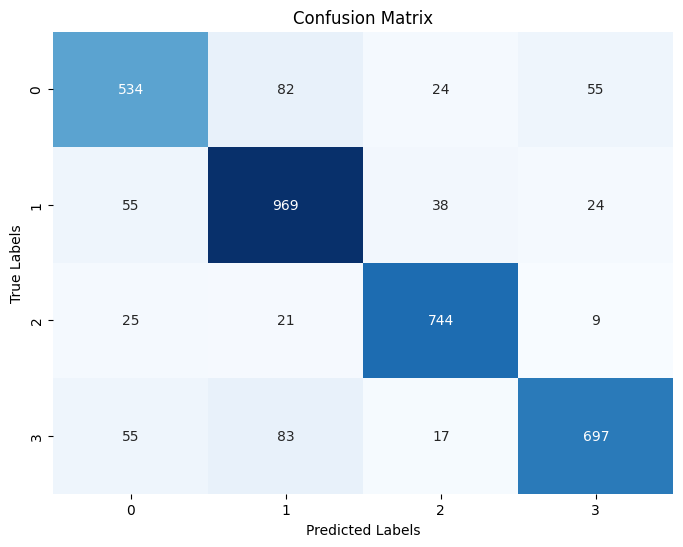

In [8]:
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()